In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [2]:
dataset = 'model/keypoint.csv'
model_save_path = 'model/aslr_model.hdf5'
tflite_save_path = 'model/aslr_model.tflite'

# Set number of classes

In [3]:
NUM_CLASSES = 24

# Dataset reading

In [4]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [5]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [8]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 20)                860       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 24)                264       
                                                                 
Total params: 1,334
Trainable params: 1,334
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [10]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [11]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
65/71 [==========================>...] - ETA: 0s - loss: 3.1312 - accuracy: 0.0531
Epoch 1: saving model to model\aslr_model.hdf5
71/71 [==============================] - 2s 8ms/step - loss: 3.1253 - accuracy: 0.0556 - val_loss: 3.0091 - val_accuracy: 0.1243
Epoch 2/1000
50/71 [====================>.........] - ETA: 0s - loss: 2.9492 - accuracy: 0.1217
Epoch 2: saving model to model\aslr_model.hdf5
71/71 [==============================] - 0s 4ms/step - loss: 2.9085 - accuracy: 0.1287 - val_loss: 2.6696 - val_accuracy: 0.2150
Epoch 3/1000
61/71 [========================>.....] - ETA: 0s - loss: 2.6454 - accuracy: 0.1899
Epoch 3: saving model to model\aslr_model.hdf5
71/71 [==============================] - 0s 4ms/step - loss: 2.6267 - accuracy: 0.1949 - val_loss: 2.3633 - val_accuracy: 0.3150
Epoch 4/1000
69/71 [============================>.] - ETA: 0s - loss: 2.3997 - accuracy: 0.2587
Epoch 4: saving model to model\aslr_model.hdf5
71/71 [==============================] - 

In [12]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

24/24 [==============================] - 0s 2ms/step - loss: 0.4104 - accuracy: 0.9157


In [13]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [14]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 101ms/step
[6.73189115e-20 1.04850217e-13 2.04186381e-05 4.87062799e-24
 2.83361019e-38 1.65447673e-08 1.94213629e-01 7.86556244e-01
 2.61920218e-06 0.00000000e+00 1.18155887e-14 1.17344467e-10
 3.69949904e-11 5.59047214e-04 0.00000000e+00 1.62026412e-13
 1.89630018e-18 0.00000000e+00 1.59995519e-02 2.47823799e-14
 1.12531154e-29 0.00000000e+00 2.64856196e-03 3.96813229e-35]
7


# Confusion matrix

94/94 [==============================] - 0s 1ms/step


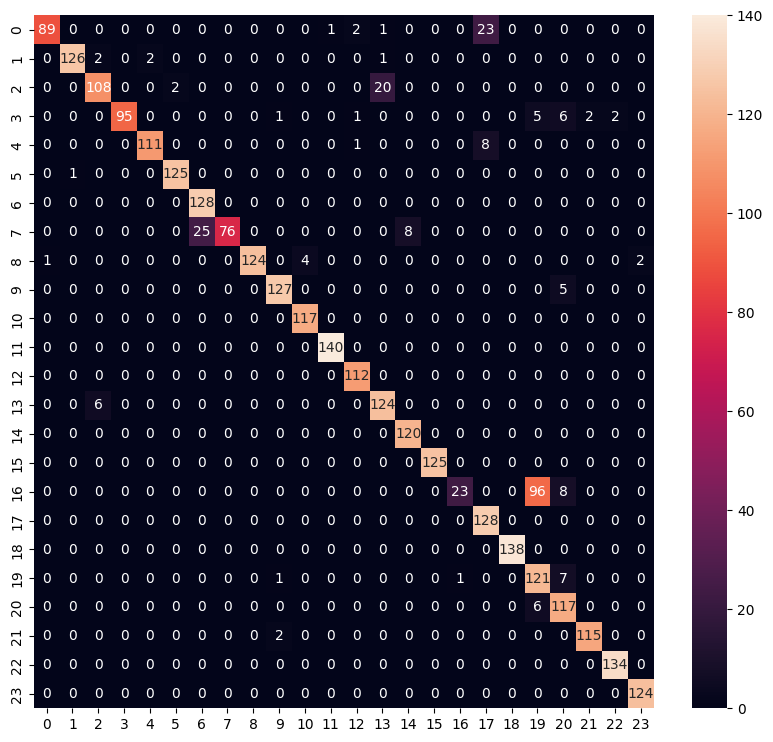

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.77      0.86       116
           1       0.99      0.96      0.98       131
           2       0.93      0.83      0.88       130
           3       1.00      0.85      0.92       112
           4       0.98      0.93      0.95       120
           5       0.98      0.99      0.99       126
           6       0.84      1.00      0.91       128
           7       1.00      0.70      0.82       109
           8       1.00      0.95      0.97       131
           9       0.97      0.96      0.97       132
          10       0.97      1.00      0.98       117
          11       0.99      1.00      1.00       140
          12       0.97      1.00      0.98       112
          13       0.85      0.95      0.90       130
          14       0.94      1.00      0.97       120
          15       1.00      1.00      1.00       125
          16       0.96      0.18      0.30       127
     

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(10, 9))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [16]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [17]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\Sam\AppData\Local\Temp\tmpihnd62pm\assets


INFO:tensorflow:Assets written to: C:\Users\Sam\AppData\Local\Temp\tmpihnd62pm\assets


7424

# Inference test

In [18]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [19]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [20]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [21]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [22]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[6.73189503e-20 1.04849872e-13 2.04185890e-05 4.87063036e-24
 3.69837165e-38 1.65447425e-08 1.94213182e-01 7.86556661e-01
 2.61920081e-06 0.00000000e+00 1.18156624e-14 1.17344523e-10
 3.69950078e-11 5.59046515e-04 0.00000000e+00 1.62026479e-13
 1.89630121e-18 0.00000000e+00 1.59995463e-02 2.47823409e-14
 1.12531214e-29 0.00000000e+00 2.64856569e-03 3.96810388e-35]
7
